In [41]:
import numpy as np 
import pandas as pd 
import time
pd.set_option('display.max_columns', None) 


# PREPROCESAMIENTO
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score


# PIPELINES
from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import set_config
# configuración para mostrar los pipelines de modo grafico
set_config(display=None)


# MODELOS
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

import shelve

# VISUALIACIÓN
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## Accedemos a los datos crudos

In [2]:
#Establezco la dirección del archivo
file_location="twic_master.csv"

#Leo el data set usando la librería pandas y se almacena en el objeto Dataframe llamado datos_crudos  
datos_crudos=pd.read_csv(file_location)

In [3]:
print("El tamaño del dataset original es de:")
datos_crudos.shape

El tamaño del dataset original es de:


(1971319, 29)

In [4]:
#Listamos todas las columnas del dataset
datos_crudos.columns

Index(['twic_number', 'White', 'Black', 'Date', 'EventDate', 'Event', 'Result',
       'mainline_moves', 'Site', 'Online', 'Round', 'ECO', 'Opening',
       'WhiteFideId', 'BlackFideId', 'WhiteElo', 'BlackElo', 'Variation',
       'WhiteTitle', 'BlackTitle', 'WhiteTeam', 'BlackTeam', 'EventType',
       'FEN', 'SetUp', 'Variant', 'Board', 'PlyCount', 'EventCategory'],
      dtype='object')

## Definimos el preprocesamiento para el pipeline con una función:

In [5]:
#Funcion para crear la columna cantidad de movimientos
def cant_mov(x):
    if type(x) is str:
        return len(x.replace(" ", "").split('.'))
    else:
        return np.NaN

#Definimos una función que se aplicará sobre cada registro para limpiar resultados
def limpiar_resultado(x):
    if x=='1-0':
        return 0
    elif x=='0-1':
        return 1
    elif x=='1/2-1/2':
        return 2
    else: 
        return np.NaN


#Funcion pre-pipeline (con control="blitz","rapid" de tiempo para elegir)

def pre_pipeline(X, control):
        #Filtro juegos de 960
        X = X[ (datos_crudos.Variant.isna()) & (datos_crudos.FEN.isna()) & (datos_crudos.SetUp.isna()) ]
        # Despues tiro estas columnas que ya no me dicen nada
        #X = X.drop(["Variant", "FEN", "SetUp"], axis=1)

        #Ponemos columnas en minuscula
        cols = ['Event', 'Opening', 'Variation', 'EventType']
        for feature in cols:
                X[feature] = X[feature].str.lower().str.strip()

        #Filtro control de tiempo
        
        X=X[(X.Event.str.contains(control)) | (X.EventType.str.contains(control))]
        # Quitamos las columnas event y eventype
        #X=X.drop(columns=['Event', 'EventType'])

        #Pasamos la columna a Date
        X["Date"] = pd.to_datetime(X["Date"])
        #Filtramos aquellos años que esten dos desvíos standar por debajo de la media
        X=X.loc[X['Date'].dt.year>X['Date'].dt.year.mean()-3*X['Date'].dt.year.std()] 
        
        #FILTRO RESULTADOS MAL CARGADOS
        X = X[(X.Result=="1-0") | (X.Result=="0-1") | (X.Result=="1/2-1/2")]
    
        #Limpiamos Resultado
        X['Result'] = X['Result'].apply(limpiar_resultado)  

        #PISO "mainline_moves" con el nro de movidas
        X['mainline_moves'] = X['mainline_moves'].apply(cant_mov) 
        
        #ELIMINO registros con nans en Elo ó ID
        X=X.dropna(subset=["WhiteElo","BlackElo","WhiteFideId","BlackFideId"])
        
        X['WhiteFideId'] = pd.to_numeric(X['WhiteFideId']).convert_dtypes() 
        X['BlackFideId'] = pd.to_numeric(X['BlackFideId']).convert_dtypes()

        # Ahora vuelvo los IDs a str, ya que luego les haré ohe
        X.WhiteFideId = X.WhiteFideId.astype(str)
        X.BlackFideId = X.BlackFideId.astype(str)

        # Y los Elos los paso a enteros
        X.WhiteElo = X.WhiteElo.astype(int)
        X.BlackElo = X.BlackElo.astype(int)

        X=X.dropna(subset=["mainline_moves","Opening"])

        return X


In [6]:
df_bz=pre_pipeline(datos_crudos, "blitz")
df_rd=pre_pipeline(datos_crudos, "rapid")

In [7]:
df_bz.dtypes

twic_number                int64
White                     object
Black                     object
Date              datetime64[ns]
EventDate                 object
Event                     object
Result                     int64
mainline_moves           float64
Site                      object
Online                      bool
Round                     object
ECO                       object
Opening                   object
WhiteFideId               object
BlackFideId               object
WhiteElo                   int32
BlackElo                   int32
Variation                 object
WhiteTitle                object
BlackTitle                object
WhiteTeam                 object
BlackTeam                 object
EventType                 object
FEN                       object
SetUp                    float64
Variant                   object
Board                    float64
PlyCount                 float64
EventCategory            float64
dtype: object

In [8]:
display(df_bz.shape, df_rd.shape)

(89800, 29)

(67658, 29)

# DATASETS LIMPIOS Y SEPARADOS POR CONTROL DE TIEMPO

## Los datos crudos pasan por la función de facu y salen los dos dataframes de blitz y rapid con 29 columnas cada uno.

(ES IMPORTANTE QUE ENTRE CON LAS 29 COLUMNAS!)

Las dos celdas que siguen generan cada uno de los dataframes:

In [9]:
#url_bz = 'https://raw.githubusercontent.com/Facundo-Peloso/DH-TP-1---Grupo-10/main/TP%20FINAL/Chess/blitz_pipe_29.csv'
#df_bz = pd.read_csv(url_bz)

In [10]:
#url_rd = 'https://raw.githubusercontent.com/Facundo-Peloso/DH-TP-1---Grupo-10/main/TP%20FINAL/Chess/rapid_pipe_29.csv'
#df_rd = pd.read_csv(url_rd)

In [11]:
df_bz.isna().sum()

twic_number           0
White                 0
Black                 0
Date                  0
EventDate             0
Event                 0
Result                0
mainline_moves        0
Site                  0
Online                0
Round                 0
ECO                   0
Opening               0
WhiteFideId           0
BlackFideId           0
WhiteElo              0
BlackElo              0
Variation         33219
WhiteTitle        20728
BlackTitle        20951
WhiteTeam         85115
BlackTeam         85115
EventType         69407
FEN               89800
SetUp             89800
Variant           89800
Board             89800
PlyCount          89800
EventCategory     89800
dtype: int64

## Hagamos una funcion que reciba el df y separe en features  "X" y target "y", realizando también el train_test_split y devolviendo todo listo para meter en el pipeline:

In [12]:
def tts(dfr):
  # Separemos features y target
  y = dfr.Result
  X = dfr.drop(["Result"],axis=1)

  # Hagamos un split en blitz:
  return train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
  # a la funcion la llamamos igual que a un tr_ts_split, pero con el dfr con features y target de argumento

In [13]:
X_train_bz, X_test_bz, y_train_bz, y_test_bz = tts(df_bz)
X_train_rd, X_test_rd, y_train_rd, y_test_rd = tts(df_rd)

## Definamos los transformers y usémolos para armar un pipeline:

Todo en una única celda

In [14]:
X_train_bz.isna().sum()


twic_number           0
White                 0
Black                 0
Date                  0
EventDate             0
Event                 0
mainline_moves        0
Site                  0
Online                0
Round                 0
ECO                   0
Opening               0
WhiteFideId           0
BlackFideId           0
WhiteElo              0
BlackElo              0
Variation         26604
WhiteTitle        16575
BlackTitle        16735
WhiteTeam         68137
BlackTeam         68137
EventType         55554
FEN               71840
SetUp             71840
Variant           71840
Board             71840
PlyCount          71840
EventCategory     71840
dtype: int64

In [15]:
T1 = ColumnTransformer([('drop', "drop", ['twic_number', 'White', 'Black', 'Date', 'EventDate', 'Event',
                                          'Site', 'Online', 'Round', 'ECO', 'Variation','WhiteTitle',
                                          'BlackTitle', 'WhiteTeam', 'BlackTeam', 'EventType','FEN',
                                          'SetUp', 'Variant', 'Board', 'PlyCount', 'EventCategory'])], remainder = "passthrough")

T2 = ColumnTransformer(
[('imputa_movidas', SimpleImputer(strategy='mean'), [0]),
('imputa_apertura', SimpleImputer(strategy='most_frequent'), [1])],
remainder='passthrough')

T3 = ColumnTransformer(
[('ohe_ids', OneHotEncoder(min_frequency=200, handle_unknown='infrequent_if_exist', sparse_output=False), [2,3]),
('ohe_apertura', OneHotEncoder(min_frequency=2000, handle_unknown='infrequent_if_exist', sparse_output=False), [1])],
remainder = 'passthrough')


T4 = ColumnTransformer([('escaleo', MinMaxScaler(), [-1, -2, -3])], remainder = "passthrough")

arbol = DecisionTreeClassifier(max_depth=7)

pasitos = [('T1', T1), ('T2', T2), ('T3', T3), ('T4', T4), ('clf', arbol)]
pipe = Pipeline(pasitos)

## Veamos como anda el pipe con su arbolito default:

In [16]:
pipe.fit(X_train_bz, y_train_bz)

Pipeline(steps=[('T1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['twic_number', 'White',
                                                   'Black', 'Date', 'EventDate',
                                                   'Event', 'Site', 'Online',
                                                   'Round', 'ECO', 'Variation',
                                                   'WhiteTitle', 'BlackTitle',
                                                   'WhiteTeam', 'BlackTeam',
                                                   'EventType', 'FEN', 'SetUp',
                                                   'Variant', 'Board',
                                                   'PlyCount',
                                                   'EventCategory'])])),
                ('T2',
                 ColumnTransformer(remaind...
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=200,
                                                                sparse_output=False),
                                                  [2, 3]),
                                                 ('ohe_apertura',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=2000,
                                                                sparse_output=False),
                                                  [1])])),
                ('T4',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('escaleo', MinMaxScaler(),
                                                  [-1, -2, -3])])),
                ('clf', DecisionTreeClassifier(max_depth=7))])

In [17]:
y_pred_bz = pipe.predict(X_test_bz)

In [18]:
accuracy_score(y_test_bz, y_pred_bz)

0.5908129175946548

In [19]:
pipe.get_params()

{'memory': None,
 'steps': [('T1', ColumnTransformer(remainder='passthrough',
                     transformers=[('drop', 'drop',
                                    ['twic_number', 'White', 'Black', 'Date',
                                     'EventDate', 'Event', 'Site', 'Online',
                                     'Round', 'ECO', 'Variation', 'WhiteTitle',
                                     'BlackTitle', 'WhiteTeam', 'BlackTeam',
                                     'EventType', 'FEN', 'SetUp', 'Variant',
                                     'Board', 'PlyCount', 'EventCategory'])])),
  ('T2',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('imputa_movidas', SimpleImputer(), [0]),
                                   ('imputa_apertura',
                                    SimpleImputer(strategy='most_frequent'),
                                    [1])])),
  ('T3',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('

## Hagamos un gridsearch para ver cómo performan los distintos clasificadores:

In [20]:
# Y SI QUIERO COMPARAR CLASIFICADORES Y AL MISMO TIEMPO TUNEARLOS:

log_reg = LogisticRegression()
nb = BernoulliNB()
knn = KNeighborsClassifier()
svm = SVC()
mlp = MLPClassifier(max_iter=500)
dt = DecisionTreeClassifier()
et = ExtraTreesClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()


# con el nombre "M" llamo a los distintos modelos
# con el doble guion bajo "__" accedo a los hiperparámetros
# el grid entra como una lista de diccionarios

parametros = [
    {'clf': [log_reg], 'clf__C': [0.01, 0.1, 1,2, 5, 10]},
    {'clf': [rf], 'clf__n_estimators': [50, 100, 200]},
    {'clf': [dt], 'clf__max_depth': [6, 7, 8, 9, 10]},
    {'clf': [nb]},
    {'clf': [mlp]},
    {'clf': [knn], 'clf__n_neighbors': [70, 100, 130, 160]}]
    #{'clf': [xgb], 'clf__colsample_bytree': [0.2, 0.4], 'clf__max_depth': [2, 3, 4, 5]}]


folds = StratifiedKFold(n_splits=2, random_state=0, shuffle=True)
search = GridSearchCV(pipe, parametros, cv=folds, scoring="f1_micro", n_jobs=-1)

In [21]:
ini = time.time()
search.fit(X_train_bz, y_train_bz)
fin = time.time()
print(f"{(fin-ini)/60} minutos de optimización")

5.006751116116842 minutos de optimización


In [22]:
search.best_params_

{'clf': MLPClassifier(max_iter=500)}

## Veamos el score de todos los modelos:

In [23]:
res = pd.DataFrame(search.cv_results_).sort_values(by = "rank_test_score").set_index("rank_test_score").loc[:,["params","mean_test_score"]]
res

,params,mean_test_score
rank_test_score,,
1,{'clf': MLPClassifier(max_iter=500)},0.593082
2,"{'clf': KNeighborsClassifier(), 'clf__n_neighb...",0.591787
3,"{'clf': KNeighborsClassifier(), 'clf__n_neighb...",0.591439
4,"{'clf': KNeighborsClassifier(), 'clf__n_neighb...",0.589992
5,"{'clf': KNeighborsClassifier(), 'clf__n_neighb...",0.588711
6,"{'clf': LogisticRegression(), 'clf__C': 1}",0.588391
7,"{'clf': LogisticRegression(), 'clf__C': 2}",0.588377
8,"{'clf': LogisticRegression(), 'clf__C': 5}",0.588238
9,"{'clf': LogisticRegression(), 'clf__C': 10}",0.588168


## Testeamos el mejor modelo:

In [24]:
y_pred_search_bz = search.predict(X_test_bz)

accuracy_score(y_test_bz, y_pred_search_bz)

0.5978841870824053

## Visualicemos la performance del mejor modelo del gridsearch:



In [25]:
# Esta funcion toma los sets (X_test, y_test) y la predicción y_pred de un modelo
# Para entregar gráficas y métricas de score

def GRAFICAS(X_test, y_test, y_pred):
    
    y_test = pd.Series(y_test)
    y_pred = pd.Series(y_pred, index=y_test.index)
    
    c = confusion_matrix(y_test, y_pred) # mostramos la matriz de confusion
    plt.figure(figsize=(4  ,4))
    ax= plt.subplot()
    sns.heatmap(c, cmap="coolwarm", annot=True, fmt="d")
    ax.set_xlabel('Resultados predecidos')
    ax.set_ylabel('Resultados del test')
    ax.xaxis.set_ticklabels(['B(0)', 'N(1)', "T(2)"])
    ax.yaxis.set_ticklabels(['B(0)', 'N(1)', "T(2)"])
    ax.set_title('Matriz de Confusión')
    plt.show()
    

    print(f"El accuracy global del modelo es {accuracy_score(y_test, y_pred)}.")

    # Me armo un df de scores para cada resultado
    scores = pd.DataFrame({"Resultado":range(3),
                         "sensibilidad":pd.Series(recall_score(y_test, y_pred, average=None)),
                         "precisión":pd.Series(precision_score(y_test, y_pred, average=None)),
                         "f1":pd.Series(f1_score(y_test, y_pred, average=None))})
    scores.index.name='Resultado'
    print(f"\n\nEstos son los scores para cada resultado")

    display(scores.loc[:,"sensibilidad":].transpose().round(3))


    
    
    # hacemos un melt sobre Resultados para graficar
    df = scores.melt("Resultado", var_name='scores', value_name='Scores')
    # graficamos los scores para cada resultado
    sns.catplot(x="Resultado", y="Scores", hue='scores', data=df, kind='point')
    #plt.savefig(f"tp3_{type(modelo)}.png")
    plt.show()

    
    
    # Mostremos los errores cometidos

    err = y_test != y_pred # Hacemos una mascara de errores

    print(f"\n\nEstos son los errores de sensado (resultado mal identificado) y los errores de presición (resultado mal asignado):") 

    err1 = pd.DataFrame({"Mal sensado":y_test[err].value_counts(), "Mal predecido":y_pred[err].value_counts()})
    tot1 = err1["Mal sensado"].sum()
    tot2 = err1["Mal predecido"].sum()
    err1.loc["Total"] = [tot1,tot2]
    err1.index.name='Resultado'
    display(err1.transpose())

    # Un dataframe de errores:
    errores = pd.DataFrame({"y_test":y_test[err], "y_pred":y_pred[err]})
    errores["frecuencia"] = errores.apply(lambda x: c[x.y_test,x.y_pred] ,axis=1)
    errores = errores.sort_values(by=["frecuencia",'y_test', 'y_pred'],ascending=[False,False,False])

    print(f"\n\nAquí se muestra la frecuencia de cada uno de los {errores.shape[0]} errores cometidos:")
    display (errores.drop_duplicates().set_index('frecuencia').transpose())

    
    
    # Y para finalizar graficamos los errores de predicción,
    # con la perspectiva puesta en Los Elos, que son nuestros
    # mejores predictores
    X_test["Errores de Sensibilidad"] = y_test
        
    X_test["Errores de Precisión"] = y_pred
    
    
    print("\n\nEstos son los errores de recall (etiquetas del test mal predecidas):")
    sns.pairplot(X_test[err], vars=['WhiteElo', 'BlackElo'], hue = "Errores de Sensibilidad", plot_kws={"s": 1}, palette="Dark2")
    plt.show()

    # Acá se va a ver cómo los modelos predicen empates sólo para los jugadores de mayor Elo.
    print("\n\nEstos son los errores de precisión (predicciones erróneas del modelo):")
    sns.pairplot(X_test[err], vars=['WhiteElo', 'BlackElo'], hue = "Errores de Precisión", plot_kws={"s": 1}, palette="Dark2")
    plt.show()
    print("Los errores de precisión a su vez revelan las fronteras de decisión del modelo")
    
    
    # Y un poco mas en detalle el tipo de error:
    X_err = X_test.loc[err]
    X_err["(Test, Pred)"] = X_err.apply(lambda x: (x["Errores de Sensibilidad"], x["Errores de Precisión"]), axis=1)
    
    print("\n\nAquí se grafican los seis tipos de errores posibles:")
    sns.pairplot(X_err, vars=['WhiteElo', 'BlackElo'], hue = "(Test, Pred)", plot_kws={"s": 1}, palette="Paired")
    plt.show()

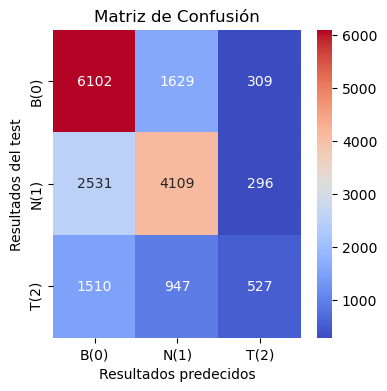

El accuracy global del modelo es 0.5978841870824053.


Estos son los scores para cada resultado


Resultado,0,1,2
sensibilidad,0.759,0.592,0.177
precisión,0.602,0.615,0.466
f1,0.671,0.603,0.256


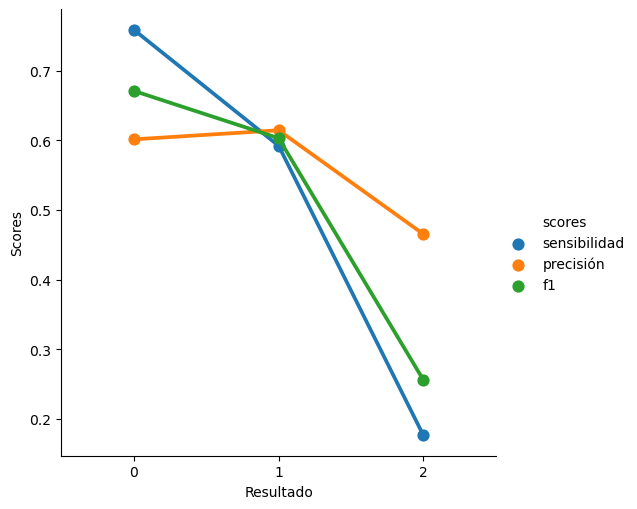



Estos son los errores de sensado (resultado mal identificado) y los errores de presición (resultado mal asignado):


Resultado,0,1,2,Total
Mal sensado,1938,2827,2457,7222
Mal predecido,4041,2576,605,7222




Aquí se muestra la frecuencia de cada uno de los 7222 errores cometidos:


frecuencia,2531,1629,1510,947,309,296
y_test,1,0,2,2,0,1
y_pred,0,1,0,1,2,2




Estos son los errores de recall (etiquetas del test mal predecidas):


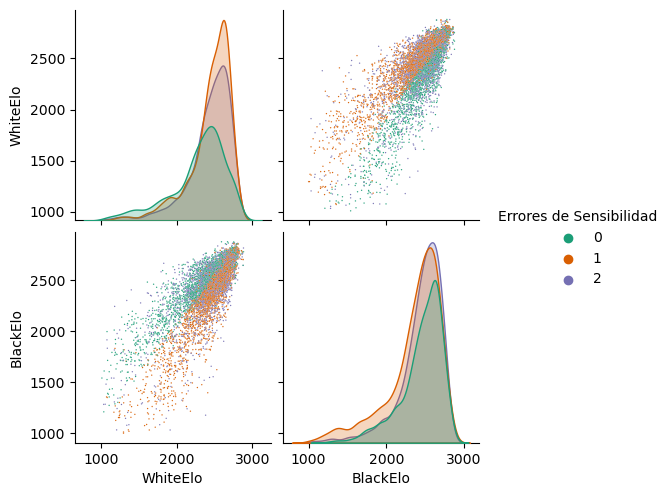



Estos son los errores de precisión (predicciones erróneas del modelo):


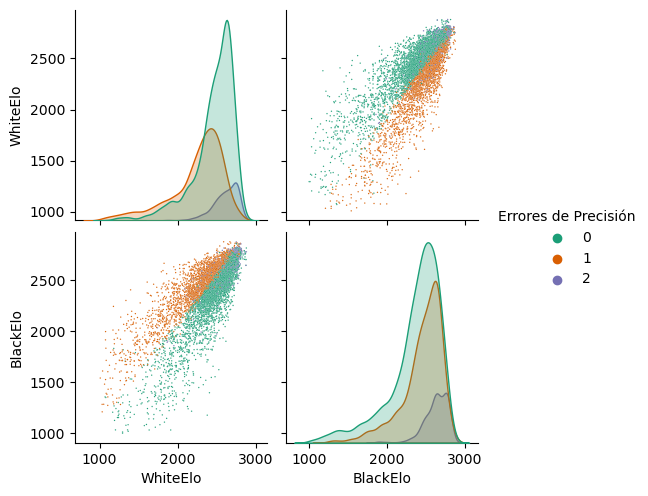

Los errores de precisión a su vez revelan las fronteras de decisión del modelo


Aquí se grafican los seis tipos de errores posibles:


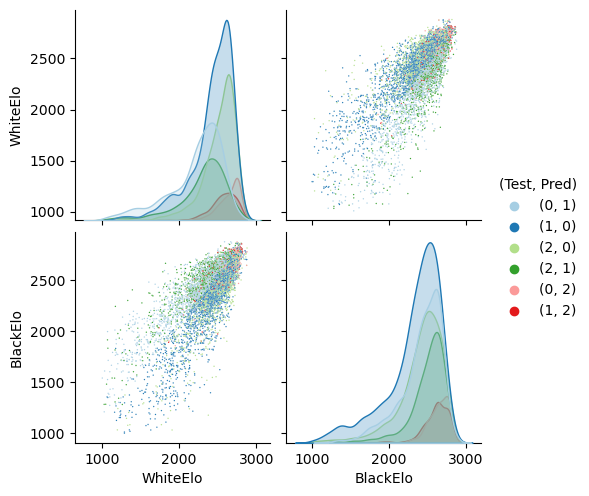

In [26]:
GRAFICAS(X_test_bz, y_test_bz, y_pred_search_bz)

## Para afinar con xgb, podemos armar un pipeline cambiando el ultimo paso y metiendo el booster como clasificador:

In [33]:
# afinemos con xgb:
display(pasitos[4])
#pongamos al xgb como ultimo paso:
pasitos[4] = ("clf", mlp)
pipe = Pipeline(pasitos)
display(pipe)

('clf', MLPClassifier(max_iter=500))

Pipeline(steps=[('T1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['twic_number', 'White',
                                                   'Black', 'Date', 'EventDate',
                                                   'Event', 'Site', 'Online',
                                                   'Round', 'ECO', 'Variation',
                                                   'WhiteTitle', 'BlackTitle',
                                                   'WhiteTeam', 'BlackTeam',
                                                   'EventType', 'FEN', 'SetUp',
                                                   'Variant', 'Board',
                                                   'PlyCount',
                                                   'EventCategory'])])),
                ('T2',
                 ColumnTransformer(remaind...
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=200,
                                                                sparse_output=False),
                                                  [2, 3]),
                                                 ('ohe_apertura',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=2000,
                                                                sparse_output=False),
                                                  [1])])),
                ('T4',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('escaleo', MinMaxScaler(),
                                                  [-1, -2, -3])])),
                ('clf', MLPClassifier(max_iter=500))])

## Además quiero cambiar hiperparámetros de los transformers, por ejemplo la cantidad de dummies a generar.

In [35]:
pipe.get_params()

{'memory': None,
 'steps': [('T1', ColumnTransformer(remainder='passthrough',
                     transformers=[('drop', 'drop',
                                    ['twic_number', 'White', 'Black', 'Date',
                                     'EventDate', 'Event', 'Site', 'Online',
                                     'Round', 'ECO', 'Variation', 'WhiteTitle',
                                     'BlackTitle', 'WhiteTeam', 'BlackTeam',
                                     'EventType', 'FEN', 'SetUp', 'Variant',
                                     'Board', 'PlyCount', 'EventCategory'])])),
  ('T2',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('imputa_movidas', SimpleImputer(), [0]),
                                   ('imputa_apertura',
                                    SimpleImputer(strategy='most_frequent'),
                                    [1])])),
  ('T3',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('

In [36]:
# 

parametros_mlp = [
    {
     'clf': [mlp],
     'clf__solver': ['lbfgs', 'sgd', 'adam'],
     'clf__validation_fraction': [0.1, 0.2, 0.5],
     #'clf__n_estimators': [100],
     #'clf__learning_rate': [0.1],
     'T3__ohe_ids__min_frequency': [100,200], # acá me meto en los hiperparámetros del preprocesamiento
     'T3__ohe_apertura__min_frequency': [2000,3000] # va ha probar con dummies para los jugadores que aparece más de 100, 200 ... veces
     # va a probar con dummies para las aperturas que aparecen más de 2000, 3000 ... veces
     
     }]



folds = StratifiedKFold(n_splits=2, random_state=0, shuffle=True)
search_mlp = GridSearchCV(pipe, parametros_mlp, cv=folds, scoring="f1_micro", n_jobs=-1)

También podría probar si es mejor imputar con la media o la mediana para las movidas, tendría que agregar:


```
'T2__imputa_movidas__strategy': ["mean", "median"]
```
al grid de parámetros.


In [37]:

ini = time.time()
search_mlp.fit(X_train_bz, y_train_bz)
fin = time.time()
print(f"{(fin-ini)/60} minutos de optimización")


46.0035518527031 minutos de optimización


In [38]:
pd.DataFrame(search_mlp.cv_results_).sort_values(by="mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_T3__ohe_apertura__min_frequency,param_T3__ohe_ids__min_frequency,param_clf,param_clf__solver,param_clf__validation_fraction,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
14,86.902748,0.446573,0.835952,0.174862,2000,200,"MLPClassifier(max_iter=500, solver='lbfgs', va...",sgd,0.5,"{'T3__ohe_apertura__min_frequency': 2000, 'T3_...",0.591481,0.584382,0.587932,0.003550,36
13,110.476283,14.360982,0.868532,0.116835,2000,200,"MLPClassifier(max_iter=500, solver='lbfgs', va...",sgd,0.2,"{'T3__ohe_apertura__min_frequency': 2000, 'T3_...",0.592567,0.583408,0.587987,0.004580,35
12,119.023502,0.990493,1.234663,0.135277,2000,200,"MLPClassifier(max_iter=500, solver='lbfgs', va...",sgd,0.1,"{'T3__ohe_apertura__min_frequency': 2000, 'T3_...",0.592233,0.583797,0.588015,0.004218,34
32,92.343534,0.662463,1.259030,0.038020,3000,200,"MLPClassifier(max_iter=500, solver='lbfgs', va...",sgd,0.5,"{'T3__ohe_apertura__min_frequency': 3000, 'T3_...",0.592957,0.583157,0.588057,0.004900,33
30,85.641225,7.252675,0.691979,0.011925,3000,200,"MLPClassifier(max_iter=500, solver='lbfgs', va...",sgd,0.1,"{'T3__ohe_apertura__min_frequency': 3000, 'T3_...",0.592622,0.584271,0.588447,0.004176,32
31,81.915492,5.248560,0.812624,0.245649,3000,200,"MLPClassifier(max_iter=500, solver='lbfgs', va...",sgd,0.2,"{'T3__ohe_apertura__min_frequency': 3000, 'T3_...",0.592261,0.584688,0.588474,0.003786,31
22,116.070286,11.536686,1.702477,0.018058,3000,100,"MLPClassifier(max_iter=500, solver='lbfgs', va...",sgd,0.2,"{'T3__ohe_apertura__min_frequency': 3000, 'T3_...",0.591231,0.585774,0.588502,0.002728,30
23,117.609084,2.612728,1.505209,0.142520,3000,100,"MLPClassifier(max_iter=500, solver='lbfgs', va...",sgd,0.5,"{'T3__ohe_apertura__min_frequency': 3000, 'T3_...",0.591036,0.586386,0.588711,0.002325,29
21,115.219895,6.659855,2.198791,0.304261,3000,100,"MLPClassifier(max_iter=500, solver='lbfgs', va...",sgd,0.1,"{'T3__ohe_apertura__min_frequency': 3000, 'T3_...",0.592344,0.586386,0.589365,0.002979,28
5,130.749368,7.282758,1.525842,0.184872,2000,100,"MLPClassifier(max_iter=500, solver='lbfgs', va...",sgd,0.5,"{'T3__ohe_apertura__min_frequency': 2000, 'T3_...",0.592066,0.586804,0.589435,0.002631,27


In [39]:
y_search_mlp_bz = search_mlp.predict(X_test_bz)

In [40]:
accuracy_score(y_test_bz, y_search_mlp_bz)

0.5941536748329621

# Almacenamos modelos 

In [42]:
models = shelve.open('modelos.db')

models['mlp']=search_mlp

models.close()